In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import *
from utils.datetime import convert_to_pd_timestamp
from utils.maps import (location_map, zurich_map, penumbra_map, compactness_map,
                        xray_class_map, inverse_mapping)

from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [301]:
df_sunspot = pd.read_csv("../data/sunspot-processed-2.csv")
df_flares = pd.read_csv("../data/flares-processed-2.csv")

In [302]:
df_flares['Start'] = pd.to_datetime(df_flares['Start'])
df_flares['End'] = pd.to_datetime(df_flares['End'])
df_flares['Maximum'] = pd.to_datetime(df_flares['Maximum'])

df_sunspot_no_null = df_sunspot.dropna(subset=['Region', 'Sunspot Number'])
df_flares_no_null = df_flares.dropna(subset=['Region', 'X-ray class', 'X-ray intensity'])

df_sunspot_no_null['Region'] = df_sunspot_no_null['Region'].astype(int)
df_flares_no_null['Region'] = df_flares_no_null['Region'].astype(int)

df_sunspot_no_null.to_csv("../data/sunspot-processed-nonull-R.csv", index=False)
df_flares_no_null.to_csv("../data/flares-processed-nonull-R.csv", index=False)

/tmp/ipykernel_67921/834412977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sunspot_no_null['Region'] = df_sunspot_no_null['Region'].astype(int)
/tmp/ipykernel_67921/834412977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flares_no_null['Region'] = df_flares_no_null['Region'].astype(int)


In [219]:
df_sunspot.shape, df_flares.shape

((276981, 10), (78812, 9))

In [220]:
get_null_counts(df_sunspot)

Region                2149
Sunspot Number       36505
Size                 50131
Zurich Class         36625
Penumbra Class       36687
Compactness Class    75774
dtype: int64

In [291]:
df_sunspot.dropna(subset=['Region', 'Sunspot Number'], inplace=True)
df_sunspot.shape

(238357, 10)

In [222]:
get_null_counts(df_flares)

Region             33801
X-ray class           26
X-ray intensity       29
dtype: int64

In [223]:
_tmp_df_sunspot = df_sunspot[['Year', 'Month', 'Day', 'Region']]
_tmp_df_sunspot['Date'] = pd.to_datetime(_tmp_df_sunspot[['Year', 'Month', 'Day']])
# _tmp_df_sunspot.set_index('Date', inplace=True)
# _tmp_df_sunspot['Region'] = _tmp_df_sunspot['Region'].replace(np.nan, -1)
_tmp_df_sunspot['Region'].isnull().sum()

/tmp/ipykernel_67921/1876020546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df_sunspot['Date'] = pd.to_datetime(_tmp_df_sunspot[['Year', 'Month', 'Day']])


0

In [224]:
_tmp_df_sunspot_day = (df_sunspot[['Year', 'Month', 'Day', 'Region', 'Sunspot Number']]
                    .groupby(['Year', 'Month', 'Day'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

_tmp_df_sunspot_month = df_sunspot[['Year', 'Month', 'Region', 'Sunspot Number']]
_tmp_df_sunspot_month = (_tmp_df_sunspot_month
                    .groupby(['Year', 'Month'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())
_tmp_df_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_df_sunspot_day.shape, _tmp_df_sunspot_month.shape

((13049, 4), (501, 4))

### Per day

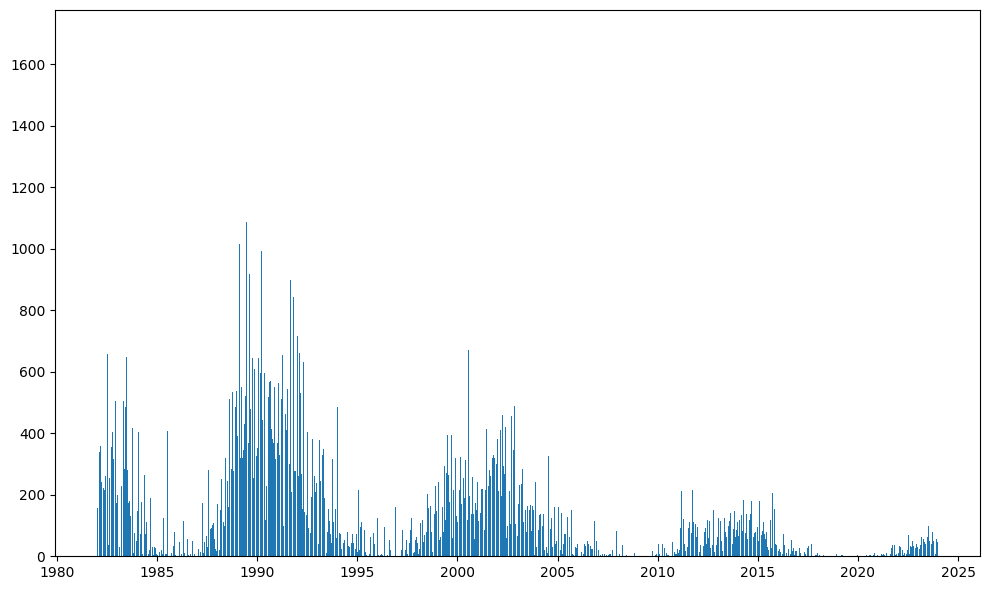

In [225]:
plt.figure(figsize=(10, 6))
plt.bar(pd.to_datetime(_tmp_df_sunspot_day[['Year', 'Month', 'Day']]),
         _tmp_df_sunspot_day['Sunspot Number'])
plt.tight_layout()

### per month

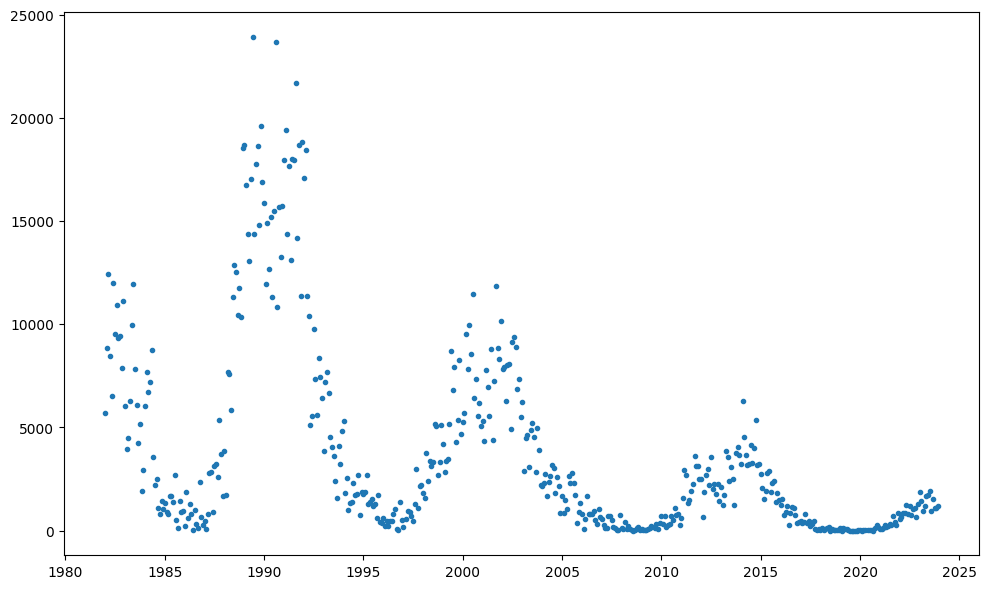

In [226]:
plt.figure(figsize=(10, 6))
plt.scatter(_tmp_df_sunspot_month['Date'],
         _tmp_df_sunspot_month['Sunspot Number'], marker='.')
plt.tight_layout()

### per year

In [227]:
_tmp_df_sunspot_year = (df_sunspot[['Year', 'Sunspot Number']]
                    .groupby(['Year'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

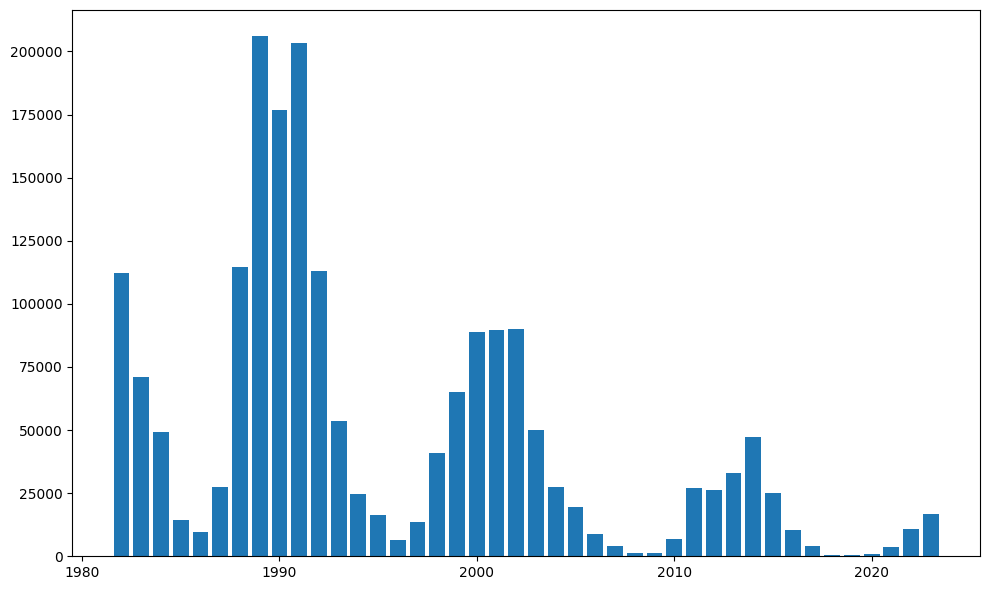

In [228]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_df_sunspot_year['Year'],
         _tmp_df_sunspot_year['Sunspot Number'])
plt.tight_layout()

## Full region

In [292]:
df_full_sunspot = pd.read_csv("../data/sunspot-processed-2.csv")
df_full_sunspot.dropna(subset=['Sunspot Number'], inplace=True)
_tmp_full_sunspot = df_full_sunspot[['Year', 'Month', 'Day']]

_tmp_full_sunspot_day = (df_full_sunspot[['Year', 'Month', 'Day', 'Sunspot Number']]
                    .groupby(['Year', 'Month', 'Day'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

_tmp_full_sunspot_month = df_full_sunspot[['Year', 'Month', 'Sunspot Number']]
_tmp_full_sunspot_month = (_tmp_full_sunspot_month
                    .groupby(['Year', 'Month'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())
_tmp_full_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_full_sunspot_year = (df_full_sunspot[['Year', 'Sunspot Number']]
                    .groupby(['Year'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

In [230]:
_tmp_full_sunspot_year['Sunspot Number'].sum(), _tmp_df_sunspot_year['Sunspot Number'].sum()

(1916904.0, 1912663.0)

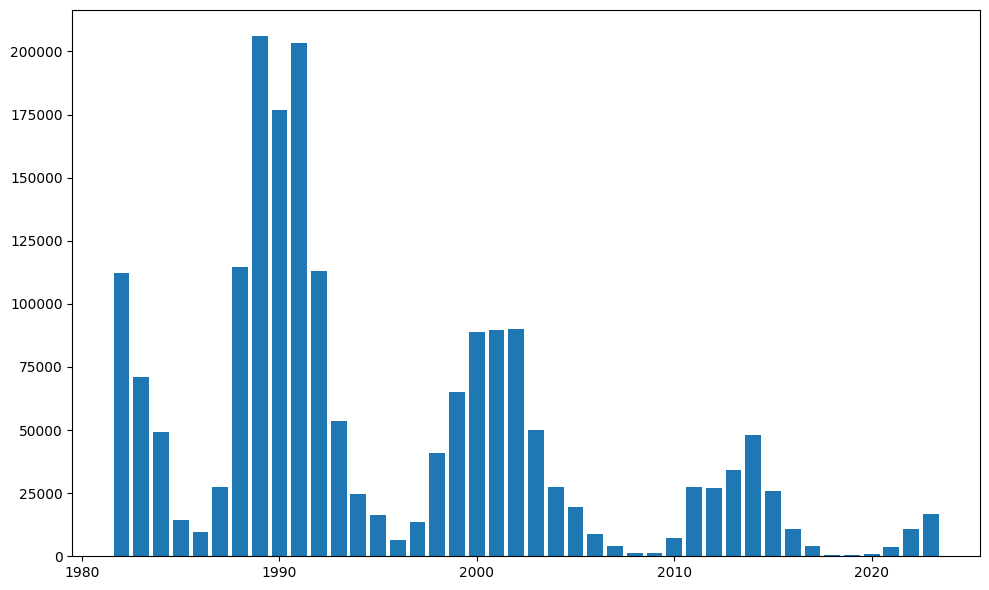

In [231]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_sunspot_year['Year'],
         _tmp_full_sunspot_year['Sunspot Number'])
plt.tight_layout()

## Flares

In [293]:
df_flares = df_flares.dropna(subset=['X-ray class', 'X-ray intensity'])
df_noR_flares = df_flares.dropna(subset=['Region'])
df_flares.shape, df_noR_flares.shape

((78783, 9), (44984, 9))

In [294]:
df_flares.groupby('Year').size().reset_index(name='Flares')

,Year,Flares
0,1982,3851
1,1983,2583
2,1984,2180
3,1985,1064
4,1986,916
5,1987,1389
6,1988,2367
7,1989,2609
8,1990,2630
9,1991,3324


In [234]:
(df_flares[['Year', 'Month', 'Day']]
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

,Year,Month,Day,Flares
0,1982,1,1,8
1,1982,1,2,9
2,1982,1,3,5
3,1982,1,4,9
4,1982,1,5,2
...,...,...,...,...
11663,2023,12,27,4
11664,2023,12,28,4
11665,2023,12,29,11
11666,2023,12,30,8


In [235]:
_tmp_full_flares = df_flares[['Year', 'Month', 'Day']]

_tmp_full_flares_day = (_tmp_full_flares
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_full_flares_month = (_tmp_full_flares
                    .groupby(['Year', 'Month'])
                    .size()
                    .reset_index(name='Flares'))

# _tmp_full_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_full_flares_year = (_tmp_full_flares[['Year']]
                    .groupby(['Year'])
                    .size()
                    .reset_index(name='Flares'))

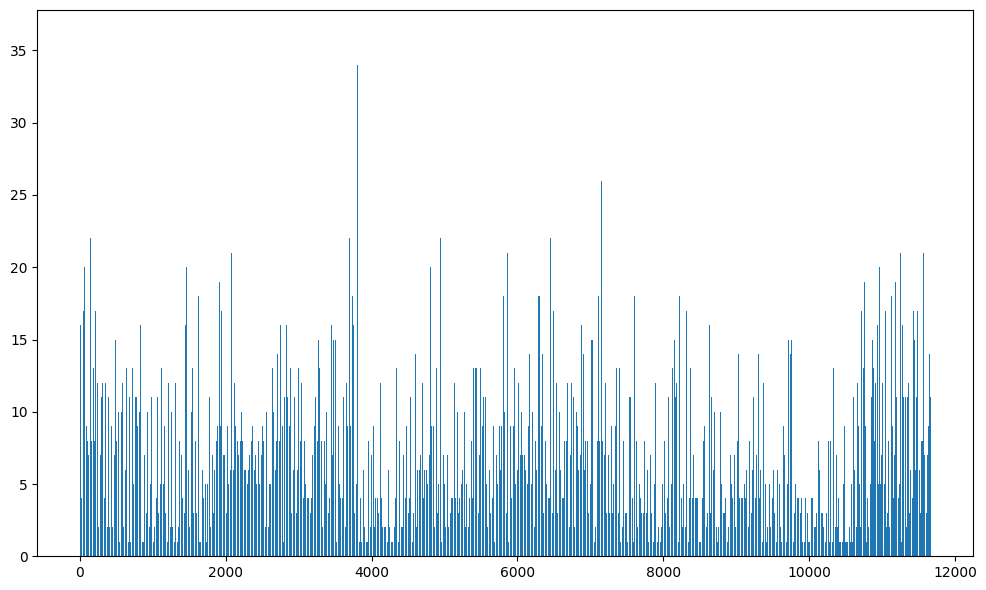

In [236]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_day.index,
         _tmp_full_flares_day['Flares'])
plt.tight_layout()

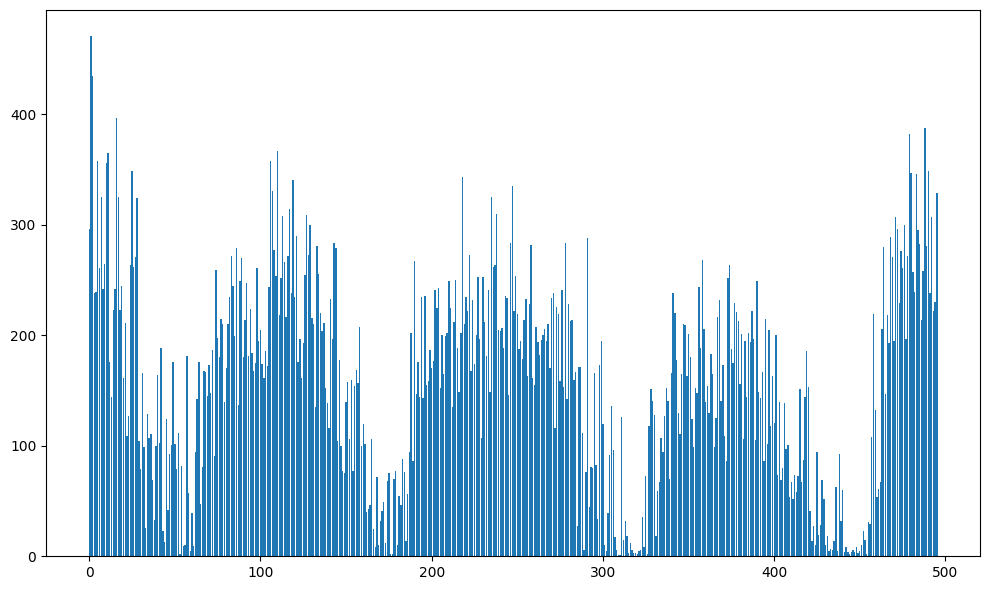

In [237]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_month.index,
         _tmp_full_flares_month['Flares'])
plt.tight_layout()

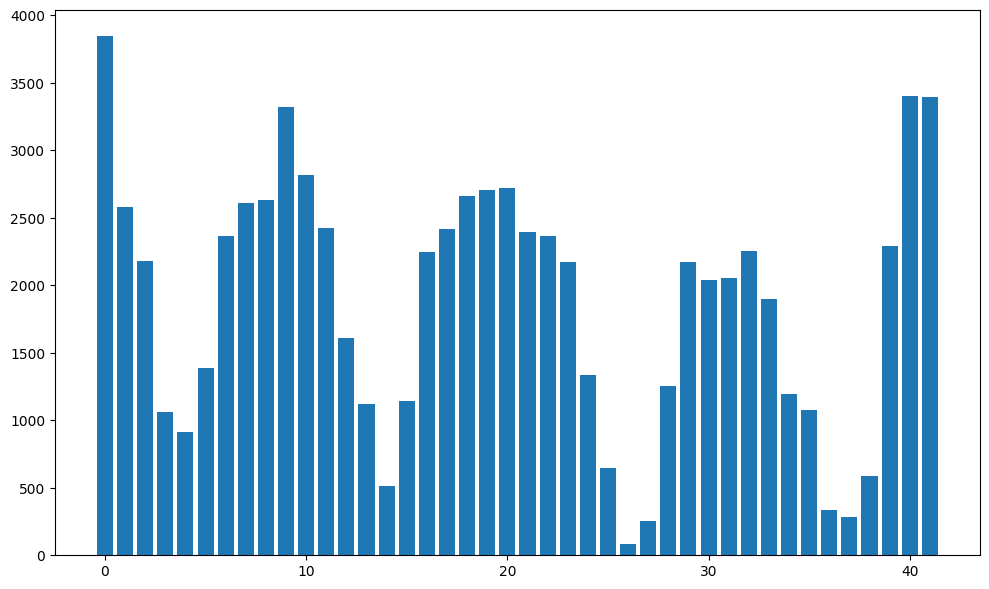

In [238]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_year.index,
         _tmp_full_flares_year['Flares'])
plt.tight_layout()

## NO region

In [239]:
_tmp_noR_flares = df_flares[['Year', 'Month', 'Day', 'Region']]
_tmp_noR_flares = _tmp_noR_flares.dropna()
_tmp_noR_flares = _tmp_noR_flares[['Year', 'Month', 'Day']]

_tmp_noR_flares_day = (_tmp_noR_flares
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_noR_flares_month = (_tmp_noR_flares
                    .groupby(['Year', 'Month'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_noR_flares_year = (_tmp_noR_flares[['Year']]
                    .groupby(['Year'])
                    .size()
                    .reset_index(name='Flares'))

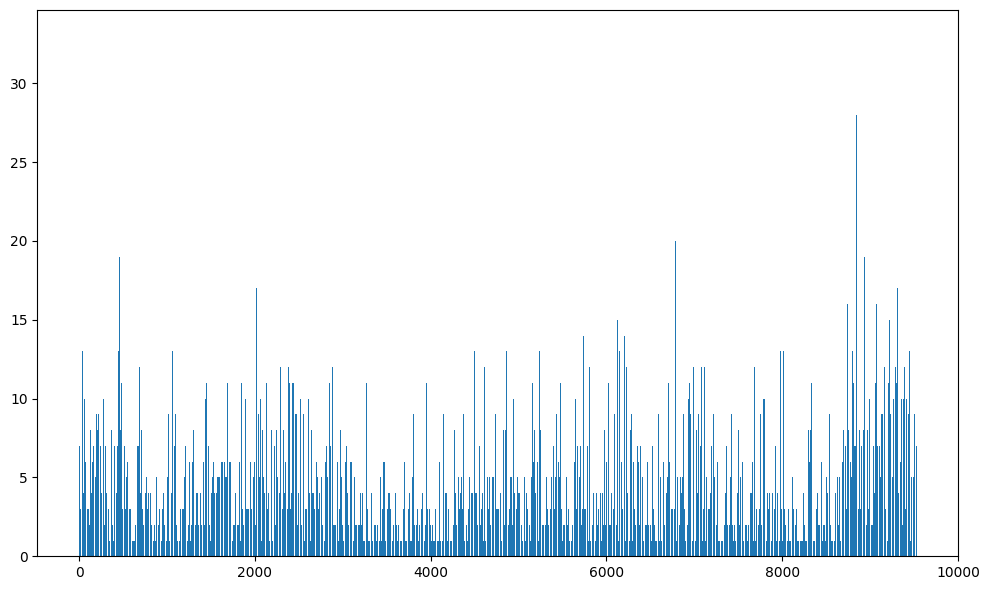

In [240]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_day.index,
         _tmp_noR_flares_day['Flares'])
plt.tight_layout()

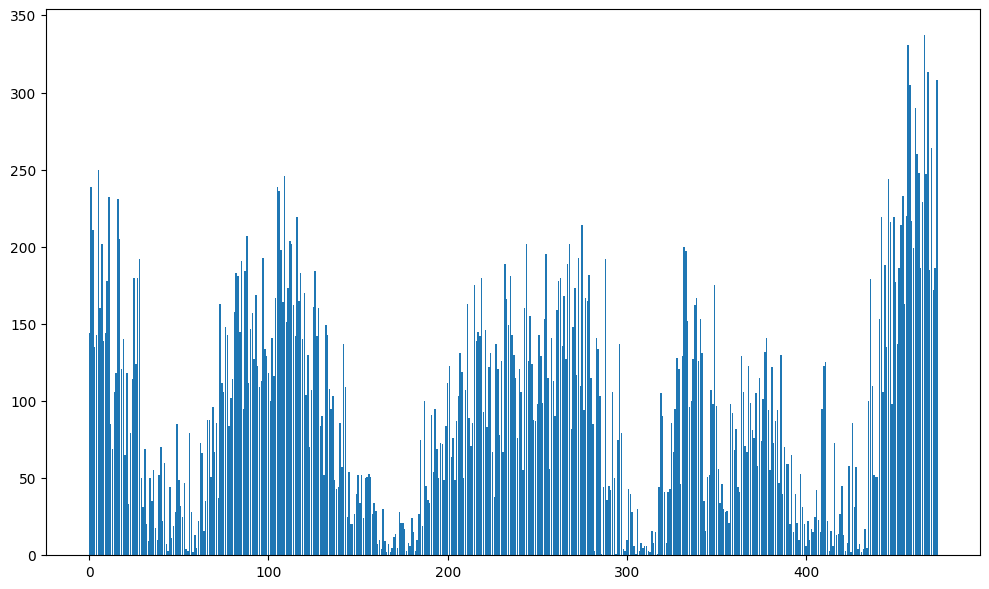

In [241]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_month.index,
         _tmp_noR_flares_month['Flares'])
plt.tight_layout()

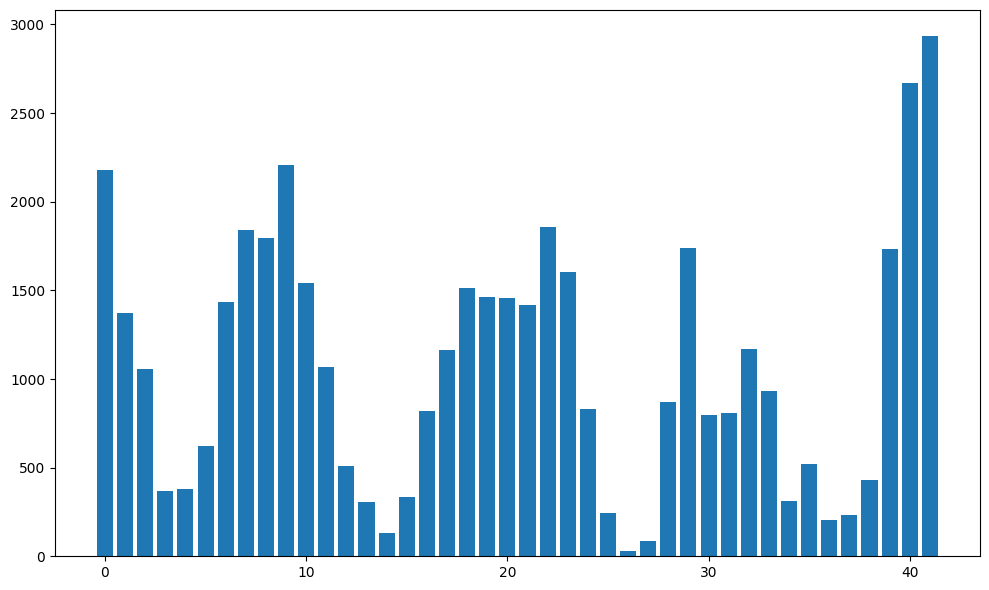

In [242]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_year.index,
         _tmp_noR_flares_year['Flares'])
plt.tight_layout()

# Interpolation

In [243]:
"""
  :return accuracy, updated values, missing value index
"""
def interpolate_by_ML(x, y, model_name):  # rf, svm
  # Combine x and y into a DataFrame
  _df = pd.DataFrame({'x': x, 'y': y})

  # Separate known and missing values
  known_data = _df.dropna()
  missing_data = _df[_df.isnull().any(axis=1)]

  # Select the model based on the model name
  if model_name == 'rf':
    _model = RandomForestRegressor(n_estimators=200)
  elif model_name == 'svm':
    _model = SVR()
  else:
    raise ValueError("Unsupported model name. Choose from 'random_forest', or 'svm'.")

  # Train the model on known data
  X_known = known_data[['x']]
  y_known = known_data['y']
  print("fitting.")
  _model.fit(X_known, y_known)

  # Predict missing values
  if not missing_data.empty:
    X_missing = missing_data[['x']]
    y_pred = _model.predict(X_missing)
    _df.loc[missing_data.index, 'y'] = y_pred

  _accuracy = _model.score(X_known, y_known)

  return _accuracy, _df['y'].values, missing_data.index

In [244]:
_tmp_df_flares = df_flares.copy()
_tmp_df_flares['Date'] = pd.to_datetime(_tmp_df_flares[['Year', 'Month', 'Day']])

In [245]:
_x_for_intpl = _tmp_df_flares['Date'].values
_y_for_intpl = _tmp_df_flares['Region'].values
accuracy_rf, filled_y_rf, missing_index = interpolate_by_ML(_x_for_intpl, _y_for_intpl, 'rf')
# accuracy_svm, filled_y_svm, _ = interpolate_by_ML(_x_for_intpl, _y_for_intpl, 'svm')

accuracy_rf

fitting.


0.999340651168747

In [246]:
def get_pre_and_next_row_of_nan(_df, _col):
  _mask = _df[_col].isna() | _df[_col].isna().shift(-1) | _df[_col].isna().shift(1)
  return _df[_mask]

# ML interpolation result

In [247]:
_iter_sunspot_ip_region = iter(filled_y_rf)
_tmp_df_sunspot['Region2'] = _tmp_df_sunspot['Region'].apply(lambda val: val if not pd.isna(val) else next(_iter_sunspot_ip_region))

get_pre_and_next_row_of_nan(_tmp_df_sunspot, 'Region')[['Region', 'Region2']]

/tmp/ipykernel_67921/3018324671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df_sunspot['Region2'] = _tmp_df_sunspot['Region'].apply(lambda val: val if not pd.isna(val) else next(_iter_sunspot_ip_region))


,Region,Region2


In [248]:
df_sunspot['Region'].unique()

array([ 3521.,  3522.,  3532., ..., 13534., 13535., 13536.])

In [249]:
df_sunspot[(df_sunspot['Region'] == 422) | (df_sunspot['Region'] == 1) | (df_sunspot['Region'] == 2)]

,Region,Sunspot Number,Size,Location,Year,Month,Day,Zurich Class,Penumbra Class,Compactness Class
26814,1.0,1.0,10.0,S16E38,1984,1,29,A,X,X
26815,1.0,1.0,30.0,S15E35,1984,1,29,H,A,X
26817,1.0,1.0,NaN,S15E32,1984,1,29,A,X,X
26818,1.0,1.0,NaN,S14E33,1984,1,29,A,X,X
26819,1.0,1.0,NaN,S15E28,1984,1,30,A,X,X


In [250]:
_tmp_df_sunspot['Region_dfip'] = _tmp_df_sunspot['Region'].interpolate()
get_pre_and_next_row_of_nan(_tmp_df_sunspot, 'Region')[['Region', 'Region_dfip']]

/tmp/ipykernel_67921/658347203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df_sunspot['Region_dfip'] = _tmp_df_sunspot['Region'].interpolate()


,Region,Region_dfip


# Let's ignore interpolation for now

In [251]:
df_sunspot['Region'] = df_sunspot['Region'].fillna(-1).astype(int)
df_flares['Region'] = df_flares['Region'].fillna(-1).astype(int)

# Merging

In [307]:
df_sunspot = pd.read_csv("../data/sunspot-processed-nonull-R.csv")

In [304]:
df_sunspot.head()

,Region,Sunspot Number,Size,Location,Year,Month,Day,Zurich Class,Penumbra Class,Compactness Class
0,3521,1.0,280.0,S21W84,1982,1,1,H,S,X
1,3521,1.0,40.0,S22W85,1982,1,1,H,S,X
2,3522,5.0,240.0,N20W73,1982,1,1,C,S,O
3,3522,3.0,80.0,N20W75,1982,1,1,D,A,O
4,3522,3.0,100.0,N19W85,1982,1,1,D,A,O


In [254]:
(sorted(df_sunspot['Zurich Class'].dropna().unique()),
 sorted(df_sunspot['Penumbra Class'].dropna().unique()),
 sorted(df_sunspot['Compactness Class'].dropna().unique()))

(['A', 'B', 'C', 'D', 'E', 'F', 'H', 'X'],
 ['A', 'H', 'K', 'O', 'R', 'S', 'X'],
 ['C', 'I', 'O', 'X'])

In [308]:
# Todo: commented for now
df_sunspot['Zurich Class'] = df_sunspot['Zurich Class'].map(zurich_map)
df_sunspot['Penumbra Class'] = df_sunspot['Penumbra Class'].map(penumbra_map)
df_sunspot['Compactness Class'] = df_sunspot['Compactness Class'].map(compactness_map)

# Location
df_sunspot[['NS', 'Lat', 'EW', 'Lan']] = (df_sunspot['Location']
                                          .str
                                          .extract(r'([A-Z])(\d+)([A-Z])(\d+)'))

# Todo: commented for now
# df_sunspot['NS'] = df_sunspot['NS'].map(location_map)
# df_sunspot['EW'] = df_sunspot['EW'].map(location_map)
df_sunspot.drop('Location', axis=1, inplace=True)

In [296]:
df_sunspot.drop('Region', axis=1)

,Sunspot Number,Size,Year,Month,Day,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan
0,1.0,280.0,1982,1,1,H,S,X,S,21,W,84
1,1.0,40.0,1982,1,1,H,S,X,S,22,W,85
2,5.0,240.0,1982,1,1,C,S,O,N,20,W,73
3,3.0,80.0,1982,1,1,D,A,O,N,20,W,75
4,3.0,100.0,1982,1,1,D,A,O,N,19,W,85
...,...,...,...,...,...,...,...,...,...,...,...,...
276976,12.0,150.0,2023,12,30,D,A,O,S,13,E,16
276977,1.0,160.0,2023,12,31,H,S,X,S,19,W,77
276978,2.0,20.0,2023,12,31,B,X,O,N,15,W,78
276979,10.0,120.0,2023,12,31,D,A,O,S,12,E,03


In [309]:
df_sunspot_processed = df_sunspot.copy()

# Convert date to datetime format by combining Year, Month, and Day
df_sunspot_processed['Date'] = pd.to_datetime(df_sunspot_processed[['Year', 'Month', 'Day']])
df_sunspot_processed.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)

df_sunspot_processed['Size'].fillna(0, inplace=True)

_tmp_grouped = df_sunspot_processed.groupby(['Date', 'Region'])

# Group by date
df_sunspot_processed_grouped = _tmp_grouped.agg(
  sunspot_count=('Sunspot Number', 'sum'),
  max_size=('Size', 'max'),
  max_zurich_class=('Zurich Class', 'max'),
  max_penumbra_class=('Penumbra Class', 'max'),
  max_compactness_class=('Compactness Class', 'max')
).reset_index()

df_sunspot_processed_grouped.rename(
  columns={
    'sunspot_count': 'Total Sunspot',
    'max_size': 'Max Size',
    'max_zurich_class': 'Zurich Class',
    'max_penumbra_class': 'Penumbra Class',
    'max_compactness_class': 'Compactness Class',
  }, inplace=True)

# Merge the max size rows back to get the corresponding NS, Lat, EW, Lan
max_size_rows = df_sunspot_processed.loc[_tmp_grouped['Size'].idxmax()]

# Select relevant columns
max_size_rows = max_size_rows[['Date', 'NS', 'Lat', 'EW', 'Lan', 'Region']]
df_sunspot_processed_grouped = pd.merge(df_sunspot_processed_grouped, max_size_rows, on=['Date', 'Region'])
df_sunspot_processed_grouped

/tmp/ipykernel_67921/2391512664.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sunspot_processed['Size'].fillna(0, inplace=True)


,Date,Region,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan
0,1982-01-01,3520,18.0,430.0,4.0,6.0,2.0,S,25,W,75
1,1982-01-01,3521,2.0,280.0,7.0,3.0,1.0,S,21,W,84
2,1982-01-01,3522,11.0,240.0,4.0,4.0,2.0,N,20,W,73
3,1982-01-01,3528,18.0,30.0,3.0,2.0,2.0,S,10,W,12
4,1982-01-01,3530,41.0,310.0,4.0,4.0,2.0,N,18,W,18
...,...,...,...,...,...,...,...,...,...,...,...
73053,2023-12-30,13534,12.0,150.0,4.0,4.0,2.0,S,13,E,16
73054,2023-12-31,13531,1.0,160.0,7.0,3.0,1.0,S,19,W,77
73055,2023-12-31,13533,2.0,20.0,2.0,1.0,2.0,N,15,W,78
73056,2023-12-31,13534,10.0,120.0,4.0,4.0,2.0,S,12,E,03


In [310]:
df_sunspot_processed_grouped.to_csv("../data/sunspot-grouped-by-region_date.csv", index=False)

## Flares

In [311]:
df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['X-ray class']\
                                  .map(xray_class_map) * df_flares_no_null['X-ray intensity']
df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['Max log10 X-ray intensity']\
                                  .apply(lambda _x: np.log10(_x) if _x != 0 else 0)

# df_flares_no_null.drop(['X-ray class', 'X-ray intensity'], axis=1, inplace=True)

/tmp/ipykernel_67921/3449614842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['X-ray class']\
/tmp/ipykernel_67921/3449614842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['Max log10 X-ray intensity']\


In [313]:
df_flares_no_null['Date'] = pd.to_datetime(df_flares_no_null[['Year', 'Month', 'Day']])
df_flares_no_null.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)

df_flares_no_null['Duration'] = ((df_flares_no_null['End'] - df_flares_no_null['Start'])
                                 .dt.total_seconds())
df_flares_no_null['Duration'] = df_flares_no_null['Duration'].astype(int)
df_flares_no_null.drop(columns=['Start', 'End'], axis=1, inplace=True)

df_flares_no_null['Maximum'] = df_flares_no_null['Maximum'].apply(convert_to_pd_timestamp)

/tmp/ipykernel_67921/778677980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flares_no_null['Date'] = pd.to_datetime(df_flares_no_null[['Year', 'Month', 'Day']])
/tmp/ipykernel_67921/778677980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flares_no_null.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)
/tmp/ipykernel_67921/778677980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

## Merge (no null region)

In [315]:
df_flares_no_null

,Region,X-ray class,X-ray intensity,Maximum,Max log10 X-ray intensity,Date,Duration
0,3522,M,3.1,378694860,-4.508638,1982-01-01,3360
1,3531,C,1.2,378707820,-5.920819,1982-01-01,1440
2,3531,C,2.1,378742860,-5.677781,1982-01-01,3240
3,3537,C,1.0,378750300,-6.000000,1982-01-01,480
5,3531,C,1.2,378759240,-5.920819,1982-01-01,1680
...,...,...,...,...,...,...,...
78807,13536,C,2.4,1704044760,-5.619789,2023-12-31,780
78808,13536,C,3.8,1704046560,-5.420216,2023-12-31,1560
78809,13536,C,4.2,1704047940,-5.376751,2023-12-31,960
78810,13536,M,1.0,1704049920,-5.000000,2023-12-31,3360


In [330]:
df_flares_processed_grouped = (df_flares_no_null
                               .groupby(['Date', 'Region'])
                               .agg({'Region': 'count',
                                     'Maximum': ['mean'],
                                     'Max log10 X-ray intensity': 'max',
                                     'Duration': [('Max', 'max'), ('Avg', 'mean')],
                                     })
                               .rename(columns={'count': 'count'})
                               .reset_index())


df_flares_processed_grouped.columns = [' '.join(col).strip() for col in df_flares_processed_grouped.columns.values]

df_flares_processed_grouped = df_flares_processed_grouped.rename(
  columns={'Region count': 'Flares Count',
  'Maximum mean': 'Avg Max Time',
  'Max log10 X-ray intensity max': 'Max log10 X-ray intensity',
  'Duration Max': 'Max Duration',
  'Duration Avg': 'Avg Duration'})

# picking 'X-ray class' & 'X-ray intensity' where max log10 X-ray intensity
df_flares_processed_grouped = pd.merge(df_flares_processed_grouped,
                  df_flares_no_null[['Date', 'Region', 'Max log10 X-ray intensity',
                                     'X-ray class', 'X-ray intensity']],
                  on=['Date', 'Region', 'Max log10 X-ray intensity'], how='left')

df_flares_processed_grouped

,Date,Region,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity
0,1982-01-01,3522,2,3.787330e+08,-4.508638,3360,2340.0,M,3.1
1,1982-01-01,3531,3,3.787366e+08,-5.677781,3240,2120.0,C,2.1
2,1982-01-01,3536,1,3.787676e+08,-5.050610,540,540.0,C,8.9
3,1982-01-01,3537,1,3.787503e+08,-6.000000,480,480.0,C,1.0
4,1982-01-02,3522,1,3.788004e+08,-4.091515,1680,1680.0,M,8.1
...,...,...,...,...,...,...,...,...,...
18329,2023-12-30,13530,6,1.703943e+09,-5.214670,1680,880.0,C,6.1
18330,2023-12-30,13534,1,1.703920e+09,-5.721246,1800,1800.0,C,1.9
18331,2023-12-31,10353,1,1.703982e+09,-5.677781,600,600.0,C,2.1
18332,2023-12-31,13531,1,1.703991e+09,-5.920819,1560,1560.0,C,1.2


In [331]:
df_flares_processed_grouped.to_csv("../data/flares-grouped-by-region_date.csv", index=False)

# Final merge (non-null Region)

In [341]:
# Apply the inverse mapping
df_sunspot_processed_grouped['Zurich Class'] = (df_sunspot_processed_grouped['Zurich Class']
                                                .map(inverse_mapping(zurich_map)))
df_sunspot_processed_grouped['Penumbra Class'] = (df_sunspot_processed_grouped['Penumbra Class']
                                                .map(inverse_mapping(penumbra_map)))
df_sunspot_processed_grouped['Compactness Class'] = (df_sunspot_processed_grouped['Compactness Class']
                                                .map(inverse_mapping(compactness_map)))

In [342]:
merged_df = pd.merge(df_sunspot_processed_grouped, df_flares_processed_grouped, on=['Date', 'Region'], how='left')
merged_df.fillna(0, inplace=True)
merged_df.shape

(73392, 18)

In [348]:
merged_df.drop('Region', axis=1, inplace=True)
merged_df

,Date,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity
0,1982-01-01,18.0,430.0,D,K,O,S,25,W,75,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
1,1982-01-01,2.0,280.0,H,S,X,S,21,W,84,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
2,1982-01-01,11.0,240.0,D,A,O,N,20,W,73,2.0,3.787330e+08,-4.508638,3360.0,2340.0,M,3.1
3,1982-01-01,18.0,30.0,C,R,O,S,10,W,12,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
4,1982-01-01,41.0,310.0,D,A,O,N,18,W,18,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73387,2023-12-30,12.0,150.0,D,A,O,S,13,E,16,1.0,1.703920e+09,-5.721246,1800.0,1800.0,C,1.9
73388,2023-12-31,1.0,160.0,H,S,X,S,19,W,77,1.0,1.703991e+09,-5.920819,1560.0,1560.0,C,1.2
73389,2023-12-31,2.0,20.0,B,X,O,N,15,W,78,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
73390,2023-12-31,10.0,120.0,D,A,O,S,12,E,03,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0


In [354]:
# converting 0 (int) to string
merged_df['X-ray class'] = merged_df['X-ray class'].astype(str)
merged_df['Zurich Class'] = merged_df['Zurich Class'].astype(str)
merged_df['Penumbra Class'] = merged_df['Penumbra Class'].astype(str)
merged_df['Compactness Class'] = merged_df['Compactness Class'].astype(str)

In [355]:
merged_df.to_csv("../data/final-merged.csv", index=False)

In [334]:
# missing flares
df_flares_processed_grouped.shape[0] - merged_df[merged_df['Flares Count'] != 0].shape[0]

1200

In [267]:
df_flares_processed_grouped.shape[0]

17982

In [268]:
x = df_flares_processed_grouped.shape[0] - merged_df[merged_df['Flares Count'] != 0].shape[0]
t = df_flares_processed_grouped.shape[0]
f"{round(100-(t-x)*100/t, 2)}%"

'6.57%'

# NO NEED
# Region interpolation

In [269]:
np.array(list(set(df_flares['Region']) - set(df_sunspot['Region'])))

array([    0,  7936,     2,  9346,  4615,  3215, 10000,  6159,  4886,
       11160,  4377,  4504,  3868,  6044,  3746, 11171, 11044,  4386,
         422,  4006, 11048, 11049, 11050, 13995,  4141,  2102, 13880,
       11075,  6339, 11077,  4557,  8016,  8018, 11091,  4953, 10586,
        4061, 10590,  8162, 10851, 10724, 11107,  6117,  7524,  4200,
       10985, 10859,  4715, 10607,  5745,  4343, 10363,    -1])

In [270]:
df_flares_cleaned_indices = df_flares[~df_flares['Region'].
                                   isin(set(df_flares['Region'])
                                        - set(df_sunspot['Region']))].index
df_flares_cleaned = df_flares.loc[df_flares_cleaned_indices]
df_flares_cleaned = df_flares_cleaned[df_flares_cleaned['Region'] != 1]
df_flares_cleaned['Date'] = pd.to_datetime(df_flares_cleaned[['Year', 'Month', 'Day']])
df_flares_cleaned.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)
df_flares_cleaned.shape

(44869, 7)

# NO NEED
## Polynomial Interpolation

In [271]:
x = df_flares_cleaned['Date'].apply(convert_to_pd_timestamp)
y = df_flares_cleaned['Region']

r2_values = []

# Loop through polynomial degrees from 3 to 10
degrees = range(3, 15)
for degree in degrees:
  # Fit the polynomial of the current degree
  coefficients_n = np.polyfit(x, y, degree)
  y_fit_n = np.polyval(coefficients_n, x)
  
  # Calculate R-squared for the current degree
  r2_n = r2_score(y, y_fit_n)
  r2_values.append(r2_n)

/tmp/ipykernel_67921/3889142847.py:10: RankWarning: Polyfit may be poorly conditioned
  coefficients_n = np.polyfit(x, y, degree)
/tmp/ipykernel_67921/3889142847.py:10: RankWarning: Polyfit may be poorly conditioned
  coefficients_n = np.polyfit(x, y, degree)


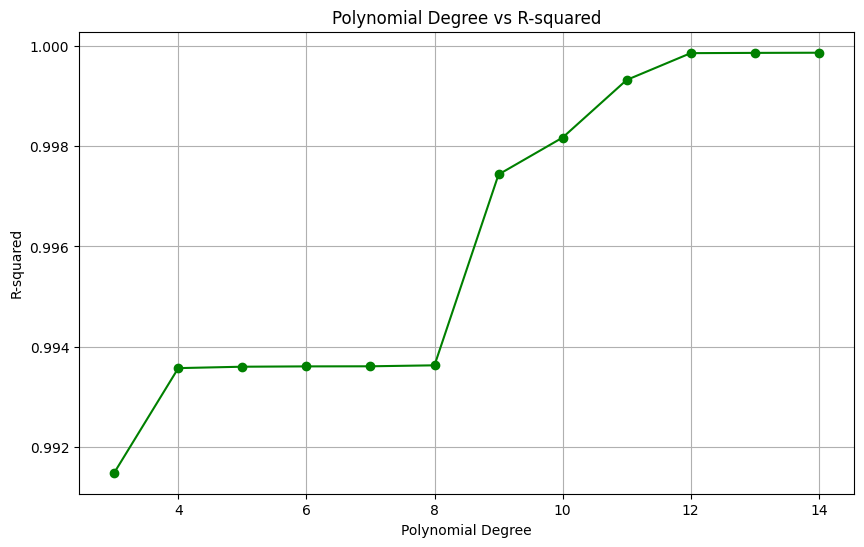

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(degrees, r2_values, marker='o', linestyle='-', color='green')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('Polynomial Degree vs R-squared')
plt.grid(True)
plt.show()

# NO NEED
## use 12th degree for interpolation

In [273]:
df_flares_with_null = pd.read_csv("../data/flares-processed-2.csv")
get_null_counts(df_flares_with_null)

Region             33801
X-ray class           26
X-ray intensity       29
dtype: int64

In [274]:
df_flares_with_null.dropna(subset=['X-ray class', 'X-ray intensity'], inplace=True)

# replace with np.nan if Region less than 3000
df_flares_with_null['Region'] = (df_flares_with_null['Region']
                                 .apply(lambda _x: _x if _x >= 3e3 else np.nan))

df_flares_with_null['Timestamp'] = pd.to_datetime(df_flares_with_null[['Year', 'Month', 'Day']]).apply(convert_to_pd_timestamp)

In [275]:
# Identify the rows where Region is not nan
not_nan_mask = ~df_flares_with_null['Region'].isna()

# Extract the x and y for non-nan positions
x_non_nan = df_flares_with_null.loc[not_nan_mask, 'Timestamp']
y_non_nan = df_flares_with_null.loc[not_nan_mask, 'Region']

In [276]:
coefficients_12th = np.polyfit(x_non_nan, y_non_nan, 20)

# polynomial function from the coefficients
polynm_func_12th_dg = np.poly1d(coefficients_12th)

df_flares_with_null['Region Interpolated'] = df_flares_with_null['Region'].copy()

# Interpolate the missing values using the polynomial function
df_flares_with_null.loc[~not_nan_mask, 'Region Interpolated'] = polynm_func_12th_dg(
  df_flares_with_null.loc[~not_nan_mask, 'Timestamp'])

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/debashis/works/dissertation/env/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_67921/3875615144.py:1: RankWarning: Polyfit may be poorly conditioned
  coefficients_12th = np.polyfit(x_non_nan, y_non_nan, 20)


In [277]:
df_flares_with_null['Region Interpolated'] = df_flares_with_null['Region Interpolated'].round()
df_flares_with_null[['Region', 'Region Interpolated']]

,Region,Region Interpolated
0,3522.0,3522.0
1,3531.0,3531.0
2,3531.0,3531.0
3,3537.0,3537.0
4,NaN,3670.0
...,...,...
78807,13536.0,13536.0
78808,13536.0,13536.0
78809,13536.0,13536.0
78810,13536.0,13536.0


In [278]:
def display_interpolated_flares_region_data(new_intpld_col):
  plt.figure(figsize=(10, 3))
  # Plot the original data (non-null values)
  plt.plot(df_flares_with_null['Timestamp'], df_flares_with_null['Region'], label='Original Data', marker='.', color='blue')
  
  # Plot the data with nulls (this will only show the non-null points)
  # plt.scatter(df_flares_with_null['Timestamp'], df_flares_with_null['Region'], label='Data with Nulls', color='red', zorder=5)
  
  # Plot the interpolated data
  plt.plot(df_flares_with_null['Timestamp'], df_flares_with_null[new_intpld_col], label='Interpolated Data', color='red', linestyle='--')
  
  # Add labels and legend
  plt.xlabel('Timestamp')
  plt.ylabel('Region')
  plt.title('Original, Data with Nulls, and Interpolated Data')
  plt.legend()
  plt.show()

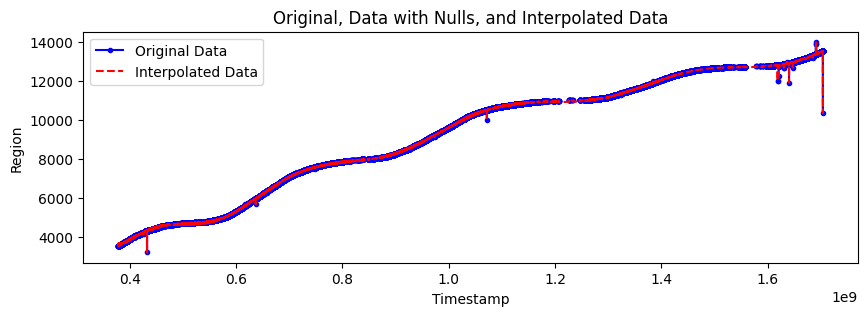

In [279]:
display_interpolated_flares_region_data('Region Interpolated')

In [280]:
df_flares_with_null['Region Interpolated pd'] = df_flares_with_null['Region'].interpolate(method='spline', order=3).round()

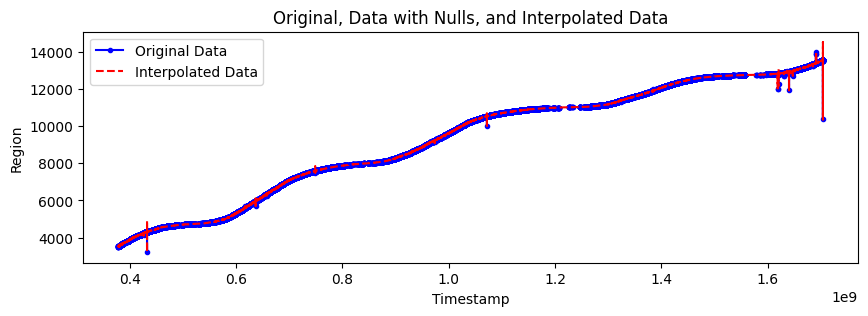

In [281]:
display_interpolated_flares_region_data('Region Interpolated pd')

In [282]:
import seaborn as sns
from sklearn.impute import KNNImputer

In [283]:
knn_imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_flares_with_null[['Timestamp', 'Region']]),
                          columns=['Timestamp', 'Region'])

In [284]:
df_flares_with_null['Region Interpolated ML1'] = df_imputed['Region'].round()
df_flares_with_null[['Region', 'Region Interpolated ML1']]

,Region,Region Interpolated ML1
0,3522.0,3522.0
1,3531.0,3531.0
2,3531.0,3531.0
3,3537.0,3537.0
4,NaN,3530.0
...,...,...
78807,13536.0,NaN
78808,13536.0,NaN
78809,13536.0,NaN
78810,13536.0,NaN


In [285]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [286]:
# Separate the data into the target variable (column with missing values) and features
target_column = 'Region'
features = df_flares_with_null['Timestamp']
target = df_flares_with_null[target_column]

# Split the data into training and testing sets, where the training set will contain non-missing values
X_train = np.array(features[target.notnull()]).reshape(-1,1)
y_train = target[target.notnull()]

# The rows where the target value is missing (to be predicted)
X_missing = np.array(features[target.isnull()]).reshape(-1,1)

# Step 2: Train a Decision Tree Regressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predict the missing values
predicted_values = model.predict(X_missing)


# Fill the missing values in the original dataset
df_flares_with_null['Region Interpolated ML2'] = df_flares_no_null['Region']
df_flares_with_null.loc[df_flares_with_null[target_column].isnull(), 'Region Interpolated ML2'] = predicted_values
df_flares_with_null['Region Interpolated ML2'] = df_flares_with_null['Region Interpolated ML2'].round()
df_flares_with_null[['Region', 'Region Interpolated ML2']]

,Region,Region Interpolated ML2
0,3522.0,3522.0
1,3531.0,3531.0
2,3531.0,3531.0
3,3537.0,3537.0
4,NaN,3530.0
...,...,...
78807,13536.0,13536.0
78808,13536.0,13536.0
78809,13536.0,13536.0
78810,13536.0,13536.0


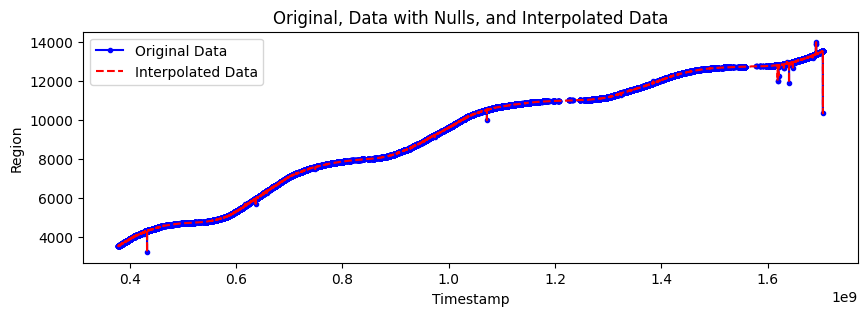

In [287]:
display_interpolated_flares_region_data('Region Interpolated ML2')

In [205]:
_x_for_intpl = df_flares_with_null['Timestamp'].values
_y_for_intpl = df_flares_with_null['Region'].values
accuracy_rf, filled_y_rf, missing_index = interpolate_by_ML(_x_for_intpl, _y_for_intpl, 'rf')

fitting.


In [ ]:
df_flares_with_null['Region Interpolated ML3'] = filled_y_rf.round()

In [215]:
df_flares_with_null[['Region', 'Region Interpolated', 'Region Interpolated pd', 'Region Interpolated ML1', 'Region Interpolated ML2', 'Region Interpolated ML3']]

,Region,Region Interpolated,Region Interpolated pd,Region Interpolated ML1,Region Interpolated ML2,Region Interpolated ML3
0,3522.0,3522.0,3522.0,3522.0,3522.0,3522.0
1,3531.0,3531.0,3531.0,3531.0,3531.0,3531.0
2,3531.0,3531.0,3531.0,3531.0,3531.0,3531.0
3,3537.0,3537.0,3537.0,3537.0,3537.0,3537.0
4,NaN,3670.0,3534.0,3530.0,3530.0,3530.0
...,...,...,...,...,...,...
78807,13536.0,13536.0,13536.0,NaN,13536.0,13536.0
78808,13536.0,13536.0,13536.0,NaN,13536.0,13536.0
78809,13536.0,13536.0,13536.0,NaN,13536.0,13536.0
78810,13536.0,13536.0,13536.0,NaN,13536.0,13536.0


# Testing

In [52]:
# Initial merge on Date and Region
_tmp_merged_df = pd.merge(df_sunspot_processed_grouped, df_flares_processed_grouped, on=['Date', 'Region'], how='left')

In [53]:
merged_df_key_set = set(zip(merged_df['Date'], merged_df['Region']))
df_flares_key_set = set(zip(df_flares_processed_grouped['Date'], df_flares_processed_grouped['Region']))

# Get the indices where df_flares_processed_grouped is not in merged_df
not_in_merged_indices = [i for i, key in enumerate(zip(df_flares_processed_grouped['Date'], df_flares_processed_grouped['Region'])) if key not in merged_df_key_set]

np.array(not_in_merged_indices)

array([    3,     4,     6, ..., 17921, 17974, 17979])

In [55]:
unmatched_flares = df_flares_processed_grouped.loc[not_in_merged_indices]
unmatched_flares['Region'].unique()

array([ 3537,  3522,  3541,  3548,  3566,  3573,  3572,  3576,  3577,
        3578,  3581,  3574,  3579,  3580,  3583,  3589,  3630,  3654,
        3695,  3659,  3672,  3675,  3693,  3714,  3715,  3716,  3746,
        3740,  3739,  3754,  3751,  3785,  3804,  3824,  3810,  3829,
        3837,  3838,  3839,  3868,  3906,  3926,  3917,  3939,  3961,
        3967,  3955,  3976,  4006,  3994,  4017,  4033,  4026,  4039,
        4047,  4051,  4038,  4044,  4061,  4062,  4079,  4081,  4082,
        2102,  4105,  4098,  4102,  4108,  4103,  4097,  4128,  4131,
        4141,  4142,  4137,  4138,  4146,  4149,  4148,  4150,  4156,
        4168,  4171,  4191,  4186,  4200,  4219,  4214,  4222,  4135,
        4254,  4249,  4251,  4263,  4236,  4296,  4303,  4308,  4319,
        3215,  4344,  4335,  4343,  4361,  4380,  4377,  4378,  4384,
        4386,  4400,  4399,  4462,  4461,  4458,  4465,  4460,  4469,
        4481,  4499,  4504,  4492,  4532,  4533,  4557,  4563,  4565,
        4582,  4602,

In [59]:
_tmp_merged_df[_tmp_merged_df['Flares Count'].isna()][['Date', 'Region']]

,Date,Region
0,1982-01-01,3520
1,1982-01-01,3521
3,1982-01-01,3528
4,1982-01-01,3530
6,1982-01-01,3532
...,...,...
73049,2023-12-30,13529
73051,2023-12-30,13531
73052,2023-12-30,13533
73055,2023-12-31,13533


In [57]:
unmatched_flares[['Date', 'Region']]

,Date,Region
3,1982-01-01,3537
4,1982-01-02,3522
6,1982-01-03,3522
10,1982-01-05,3541
20,1982-01-11,3537
...,...,...
17892,2023-12-03,13494
17898,2023-12-05,13494
17921,2023-12-13,13511
17974,2023-12-29,13528


In [154]:
_tmp = merged_df.copy()

previous_day_matched_indices = []

# Attempt to merge the unmatched flares with the previous date in df_flares_processed_grouped
for i, row in unmatched_flares.iterrows():
  previous_date = (pd.to_datetime(row['Date']) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
  
  # Find a matching row in the sunspot data with the previous date and same region
  match = df_sunspot_processed_grouped[(df_sunspot_processed_grouped['Date'] == previous_date) &
                                       (df_sunspot_processed_grouped['Region'] == row['Region'])]
  
  if not match.empty:
    # Merge the row into the merged dataframe
    _tmp = pd.concat([_tmp, match], ignore_index=True)
    
    previous_day_matched_indices.append(i)
_tmp

,Date,Region,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan,Flares Count,Avg Max Time,Max log10 X-ray Intensity,Max Duration,Avg Duration
0,1982-01-01,3520,18.0,430.0,4.0,6.0,2.0,-1.0,25,-1.0,75,0.0,0.0,0.000000,0.0,0.0
1,1982-01-01,3521,2.0,280.0,7.0,3.0,1.0,-1.0,21,-1.0,84,0.0,0.0,0.000000,0.0,0.0
2,1982-01-01,3522,11.0,240.0,4.0,4.0,2.0,1.0,20,-1.0,73,2.0,378733020.0,-4.508638,3360.0,2340.0
3,1982-01-01,3528,18.0,30.0,3.0,2.0,2.0,-1.0,10,-1.0,12,0.0,0.0,0.000000,0.0,0.0
4,1982-01-01,3530,41.0,310.0,4.0,4.0,2.0,1.0,18,-1.0,18,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85495,2023-12-28,13530,4.0,10.0,2.0,1.0,2.0,1.0,08,-1.0,59,NaN,NaN,NaN,NaN,NaN
85496,2023-12-28,13533,7.0,30.0,4.0,4.0,2.0,1.0,15,-1.0,36,NaN,NaN,NaN,NaN,NaN
85497,2023-12-29,13530,6.0,70.0,4.0,4.0,2.0,1.0,06,-1.0,77,NaN,NaN,NaN,NaN,NaN
85498,2023-12-29,13534,9.0,90.0,4.0,4.0,2.0,-1.0,12,1.0,30,NaN,NaN,NaN,NaN,NaN


In [119]:
# np.array(previous_day_matched_indices)
unmatched_flares.loc[previous_day_matched_indices]

,Date,Region,Flares Count,Avg Max Time,Max log10 X-ray Intensity,Max Duration,Avg Duration
4,1982-01-02,3522,1,3.788004e+08,-4.091515,1680,1680.0
7,1982-01-04,3531,1,3.789556e+08,-5.958607,1140,1140.0
8,1982-01-04,3537,6,3.789949e+08,-5.244125,2940,1570.0
9,1982-01-05,3531,1,3.790862e+08,-5.823909,1020,1020.0
11,1982-01-06,3537,5,3.791624e+08,-5.494850,3240,1584.0
...,...,...,...,...,...,...,...
17975,2023-12-29,13530,3,1.703861e+09,-5.187087,3120,1840.0
17976,2023-12-29,13533,5,1.703827e+09,-5.013228,1800,1188.0
17977,2023-12-30,13530,6,1.703943e+09,-5.214670,1680,880.0
17978,2023-12-30,13534,1,1.703920e+09,-5.721246,1800,1800.0


In [125]:
df_flares_processed_grouped[df_flares_processed_grouped['Region'] == 3522]

,Date,Region,Flares Count,Avg Max Time,Max log10 X-ray Intensity,Max Duration,Avg Duration
0,1982-01-01,3522,2,378733020.0,-4.508638,3360,2340.0
4,1982-01-02,3522,1,378800400.0,-4.091515,1680,1680.0
6,1982-01-03,3522,2,378876900.0,-4.721246,1500,1320.0


In [126]:
df_sunspot_processed_grouped[df_sunspot_processed_grouped['Region'] == 3522]

,Date,Region,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan
2,1982-01-01,3522,11.0,240.0,4.0,4.0,2.0,1.0,20,-1.0,73


In [139]:
sunspot_unique_set = set(df_sunspot_processed_grouped['Region'].unique())
flares_unique_set  = set(df_flares_processed_grouped['Region'].unique())

unmatched_sunspot = list(sunspot_unique_set - flares_unique_set)
unmatched_flares = list(flares_unique_set - sunspot_unique_set)

unmatched_flares

[0,
 7936,
 2,
 9346,
 4615,
 3215,
 10000,
 6159,
 4886,
 11160,
 4377,
 4504,
 3868,
 6044,
 3746,
 11171,
 11044,
 4386,
 422,
 4006,
 11048,
 11049,
 11050,
 13995,
 4141,
 2102,
 13880,
 11075,
 6339,
 11077,
 4557,
 8016,
 8018,
 11091,
 4953,
 10586,
 4061,
 10590,
 8162,
 10851,
 10724,
 11107,
 6117,
 7524,
 4200,
 10985,
 10859,
 4715,
 10607,
 5745,
 4343,
 10363]

In [140]:
df_flares_processed_grouped[df_flares_processed_grouped['Region'].isin(unmatched_flares)]

,Date,Region,Flares Count,Avg Max Time,Max log10 X-ray Intensity,Max Duration,Avg Duration
353,1982-05-19,3746,1,3.906230e+08,-6.000000,1680,1680.0
546,1982-08-18,3868,1,3.984906e+08,-5.657577,960,960.0
782,1982-11-26,4006,1,4.071914e+08,-5.096910,2100,2100.0
919,1983-01-15,4061,1,4.114399e+08,-5.853872,1140,1140.0
978,1983-03-01,2102,2,4.153927e+08,-5.958607,1860,1620.0
...,...,...,...,...,...,...,...
12847,2011-02-13,11160,2,1.297580e+09,-5.853872,2460,1440.0
12892,2011-03-08,11171,1,1.299557e+09,-4.823909,2580,2580.0
12897,2011-03-09,11171,2,1.299638e+09,-5.193820,420,390.0
17564,2023-08-01,13880,2,1.690891e+09,-4.920819,1140,840.0


In [ ]:
# Attempt to merge the unmatched flares with the previous date in df_flares_processed_grouped
for i, row in unmatched_flares.iterrows():
  previous_date = (pd.to_datetime(row['Date']) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
  
  # Find a matching row in the sunspot data with the previous date and same region
  match = df_sunspot_processed_grouped[(df_sunspot_processed_grouped['Date'] == previous_date) &
                                       (df_sunspot_processed_grouped['Region'] == row['Region'])]
  
  if not match.empty:
    # Merge the row into the merged dataframe
    merged_df = pd.concat([merged_df, match], ignore_index=True)

# Drop any duplicates that may have been merged
merged_df = merged_df.drop_duplicates(subset=['Date', 'Region'], keep='first')

# Optionally, you can sort the final dataframe by Date and Region
merged_df = merged_df.sort_values(by=['Date', 'Region'])

# Save the merged dataframe to a new CSV file
merged_df.to_csv("merged_sunspot_flares.csv", index=False)

In [247]:
df_flares = pd.read_csv("../data/flares-processed-2.csv")

In [253]:
# No region counts
df_flares[df_flares['Region'].isna()].groupby('Year').size().reset_index(name='Counts')

,Year,Counts
0,1982,1674
1,1983,1213
2,1984,1126
3,1985,693
4,1986,534
5,1987,769
6,1988,931
7,1989,771
8,1990,835
9,1991,1115


In [255]:
df_flares # 3537,3531

,Year,Month,Day,Region,X-ray class,X-ray intensity,Start,End,Maximum
0,1982,1,1,3522.0,M,3.1,1982-01-01 00:55:00,1982-01-01 01:51:00,1982-01-01 01:01:00
1,1982,1,1,3531.0,C,1.2,1982-01-01 04:35:00,1982-01-01 04:59:00,1982-01-01 04:37:00
2,1982,1,1,3531.0,C,2.1,1982-01-01 14:01:00,1982-01-01 14:55:00,1982-01-01 14:21:00
3,1982,1,1,3537.0,C,1.0,1982-01-01 16:25:00,1982-01-01 16:33:00,1982-01-01 16:25:00
4,1982,1,1,NaN,C,1.5,1982-01-01 16:41:00,1982-01-01 16:47:00,1982-01-01 16:44:00
...,...,...,...,...,...,...,...,...,...
78807,2023,12,31,13536.0,C,2.4,2023-12-31 17:38:00,2023-12-31 17:51:00,2023-12-31 17:46:00
78808,2023,12,31,13536.0,C,3.8,2023-12-31 18:02:00,2023-12-31 18:28:00,2023-12-31 18:16:00
78809,2023,12,31,13536.0,C,4.2,2023-12-31 18:28:00,2023-12-31 18:44:00,2023-12-31 18:39:00
78810,2023,12,31,13536.0,M,1.0,2023-12-31 18:44:00,2023-12-31 19:40:00,2023-12-31 19:12:00
